In [1]:
%cd ..

/home/maverick/Projects/ml-scratchpad


/home/maverick/Projects/ml-scratchpad/.venv/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
!ls

configs/          logs/       pyproject.toml    scripts/  tests/
data/             Makefile    README.md         setup.py
environment.yaml  notebooks/  requirements.txt  src/


In [11]:
import numpy as np
from matplotlib import pyplot as plt

In [141]:
import json
from pathlib import Path
from typing import Callable, Iterable, Literal, Mapping, Optional, Tuple, TypeVar, Union

import cv2
import cv2.typing
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch.utils.data import Dataset
from transformers import AutoTokenizer

StrPath = Union[str, Path]

PolygonType = Iterable[Iterable[Iterable[Tuple[int, int]]]]


class PhraseCutDataset(Dataset):
    def __init__(
        self,
        data_root: StrPath,
        task_json_path: StrPath,
        tokenizer_pretrained_path: StrPath,
        image_dir: StrPath = "images",
        transforms: Optional[Callable] = None,
        return_tensors: Literal["tf", "pt", "np"] = "np",
    ):
        super().__init__()

        data_root = Path(data_root)

        with (data_root / task_json_path).open() as f:
            self.tasks: Tuple[Mapping[str, Union[str, PolygonType]], ...] = tuple(
                json.load(f)
            )

        self.image_path = data_root / image_dir

        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_pretrained_path)
        self.return_tensors = return_tensors

        self.transforms = transforms

    def __len__(self):
        return len(self.tasks)

    def __getitem__(self, idx: int):
        task = self.tasks[idx]

        image = self.load_image(
            self.image_path / f"{task['image_id']}.jpg", cv2.IMREAD_COLOR
        )
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        text_output = self.tokenizer(
            task["phrase"],
            truncation=True,
            padding="max_length",
            return_tensors=self.return_tensors,
        )

        mask = self.polygon_to_mat(image.shape[:-1], task["Polygons"])

        if self.transforms is not None:
            transformed = self.transforms(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]

        return {"image": image, "mask": mask, **text_output}

    @staticmethod
    def load_image(path: StrPath, flags: int = cv2.IMREAD_UNCHANGED):
        str_path = str(path)

        img = cv2.imread(str_path, flags)

        if img is None:
            msg = "Image not found in the path:"
            raise ValueError(msg, str_path)

        return img

    # @staticmethod
    # def polygon_to_pil(
    #     img_size: Tuple[int, int],
    #     polygons: PolygonType,
    # ):
    #     # Create mask from polygon
    #     mask = Image.new("1", img_size)
    #     img_draw = ImageDraw.Draw(mask)
    #
    #     # Loop to add multiple polygons to the mask
    #     for poly in polygons:
    #         for p in poly:
    #             int_p = np.around(p).astype(int)
    #             img_draw.polygon(int_p.flatten().tolist(), fill=1, outline=1)
    #
    #     return mask

    @staticmethod
    def polygon_to_mat(img_size: Tuple[int, int], polygons: PolygonType):
        if len(img_size) != 2:
            msg = "The image img_size be of two dimensions"
            raise ValueError(msg)
        
        # Create an empty mask for the polygon
        mask = np.zeros(img_size, np.float32)

        # Loop to add multiple polygons to the mask
        for poly in polygons:
            pts = [np.around(p).astype(np.int32) for p in poly]
            cv2.fillPoly(mask, pts, 1.0)

        return mask

    @staticmethod
    def plot_img_mask_cut(
        img: np.ndarray,
        phrase: str,
        mask: np.ndarray,
        figsize: Tuple[int, int] = (15, 5),
    ):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=figsize)

        ax1.imshow(PhraseCutDataset.img_normalize(img))
        ax1.set_title("Image")

        mask = mask.astype(bool) 
        
        ax2.imshow(mask)
        ax2.set_title(f"Mask: {phrase}")

        # Darken the image where the mask is
        img_cut = img.copy().astype(np.float32)

        alpha = 0.7

        img_cut[mask] *= 1 - alpha

        img_cut = PhraseCutDataset.img_normalize(img_cut)

        ax3.imshow(img_cut)
        ax3.set_title("Image with Mask")

    @staticmethod
    def img_normalize(img: np.ndarray) -> np.ndarray:
        return (img - img.min()) / (img.max() - img.min())


In [142]:
ds = PhraseCutDataset(data_root="/run/media/maverick/Backup/datasets/phrasecut", task_json_path="refer_miniv.json", tokenizer_pretrained_path="openai/clip-vit-base-patch32")

In [143]:
first = ds[0]
first

{'image': array([[[194, 208, 211],
         [175, 186, 190],
         [218, 229, 233],
         ...,
         [ 29,  44,  15],
         [ 45,  59,  33],
         [ 24,  38,  12]],
 
        [[168, 182, 185],
         [183, 197, 200],
         [240, 251, 253],
         ...,
         [ 33,  48,  19],
         [ 51,  65,  39],
         [ 37,  52,  23]],
 
        [[ 97, 113, 112],
         [109, 125, 124],
         [175, 189, 189],
         ...,
         [ 46,  63,  31],
         [ 46,  62,  33],
         [ 39,  55,  26]],
 
        ...,
 
        [[ 39,  39,  39],
         [ 54,  54,  54],
         [ 11,  11,  11],
         ...,
         [142, 146, 145],
         [235, 239, 238],
         [154, 158, 157]],
 
        [[ 46,  46,  46],
         [ 35,  35,  35],
         [ 32,  32,  32],
         ...,
         [118, 122, 121],
         [114, 118, 117],
         [119, 123, 122]],
 
        [[ 33,  33,  33],
         [ 49,  49,  49],
         [ 40,  40,  40],
         ...,
         [149, 153,

In [144]:
ds.tokenizer.decode?

Signature:
ds.tokenizer.decode(
    token_ids: Union[int, List[int], ForwardRef('np.ndarray'), ForwardRef('torch.Tensor'), ForwardRef('tf.Tensor')],
    skip_special_tokens: bool = False,
    clean_up_tokenization_spaces: bool = None,
    **kwargs,
) -> str
Docstring:
Converts a sequence of ids in a string, using the tokenizer and vocabulary with options to remove special
tokens and clean up tokenization spaces.

Similar to doing `self.convert_tokens_to_string(self.convert_ids_to_tokens(token_ids))`.

Args:
    token_ids (`Union[int, List[int], np.ndarray, torch.Tensor, tf.Tensor]`):
        List of tokenized input ids. Can be obtained using the `__call__` method.
    skip_special_tokens (`bool`, *optional*, defaults to `False`):
        Whether or not to remove special tokens in the decoding.
    clean_up_tokenization_spaces (`bool`, *optional*):
        Whether or not to clean up the tokenization spaces. If `None`, will default to
        `self.clean_up_tokenization_spaces`.
    kwar

In [145]:
phrase = ds.tokenizer.decode(first["input_ids"][0], skip_special_tokens=True, clean_up_tokenization_spaces=True)
phrase

'red truck'

In [146]:
first["image"].shape, first["image"].dtype, first["mask"].shape, first["mask"].dtype

((300, 384, 3), dtype('uint8'), (300, 384), dtype('float32'))

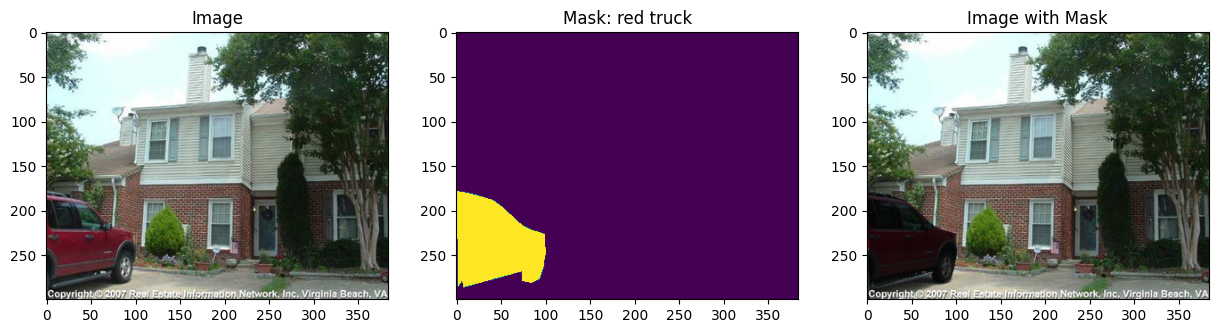

In [147]:
ds.plot_img_mask_cut(img=first["image"], phrase=phrase, mask=first["mask"])